Using device: cuda

Model Statistics:
Total Parameters: 68,007,936
Trainable Parameters: 68,007,936
Training Set Tokens: 1,082,638,872
Validation Set Tokens: 120,293,208
Total Tokens: 1,202,932,080



/tmp/ipykernel_20/637104226.py:317: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
/tmp/ipykernel_20/637104226.py:288: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Starting training...
Step 0 | Train: 10.9623 | Val: 10.9596 | PPL: 57502.55
New best checkpoint saved: latent_gpt/best_model.pt


/tmp/ipykernel_20/637104226.py:361: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx():


Step 500 | Train: 5.9199 | Val: 5.9507 | PPL: 384.02
New best checkpoint saved: latent_gpt/best_model.pt
Step 1000 | Train: 5.2770 | Val: 5.3418 | PPL: 208.88
New best checkpoint saved: latent_gpt/best_model.pt
Step 1500 | Train: 4.8992 | Val: 4.9669 | PPL: 143.58
New best checkpoint saved: latent_gpt/best_model.pt
Step 2000 | Train: 4.6285 | Val: 4.6998 | PPL: 109.92
New best checkpoint saved: latent_gpt/best_model.pt
Step 2500 | Train: 4.4082 | Val: 4.4672 | PPL: 87.11
New best checkpoint saved: latent_gpt/best_model.pt
Step 3000 | Train: 4.2856 | Val: 4.3341 | PPL: 76.26
New best checkpoint saved: latent_gpt/best_model.pt
Step 3500 | Train: 4.2437 | Val: 4.2495 | PPL: 70.07
New best checkpoint saved: latent_gpt/best_model.pt
Step 4000 | Train: 4.1308 | Val: 4.1802 | PPL: 65.38
New best checkpoint saved: latent_gpt/best_model.pt
Step 4500 | Train: 4.1321 | Val: 4.1261 | PPL: 61.94
New best checkpoint saved: latent_gpt/best_model.pt
Step 5000 | Train: 4.0728 | Val: 4.0724 | PPL: 58.70

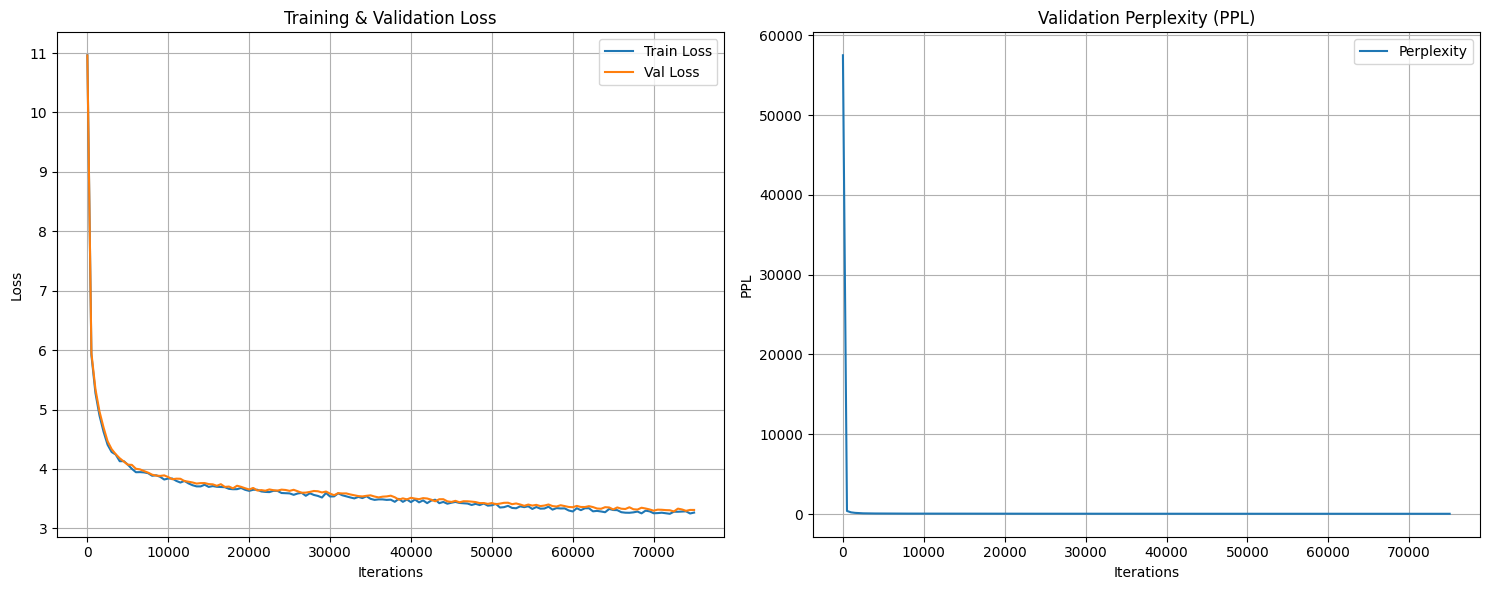


=== MODEL GENERATION DEMO ===
PROMPT: The history of science is
----------------------------------------
RESPONSE:
The history of science is still clearly the longest, but the evolution of science can be inferred from the fact that the science of science remains a fundamental part of science. computer science and engineering have a lasting influence on science and engineering.

dynamics is a method of analyzing a machine's position on a surface. the dynamics of a machine are defined by newtonian mechanics, and it is specified from the description of the machine's position on the surface of a field, which is not necessarily the same as the general
----------------------------------------


In [1]:
"""
Improved LatentGPT training script using memmap + Grouped Query Attention (GQA)
Fixes: __init__ typos, RMSNorm, RoPE handling, causal mask, weight init, small robustness fixes.
"""

import os
import json
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from contextlib import nullcontext

# Try importing tiktoken for decoding; if not found, generation will use raw IDs
try:
    import tiktoken
    HAS_TIKTOKEN = True
except Exception:
    HAS_TIKTOKEN = False
    print("WARNING: tiktoken not found. Generation will show token IDs only.")

# ================= CONFIG =================
MEMMAP_BIN_PATH = "/kaggle/input/jklu-en-memap-5gb/wikipedia_tokens.bin"
MEMMAP_META_PATH = "/kaggle/input/jklu-en-memap-5gb/wikipedia_tokens_meta.json"

# Model hyperparameters
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.1

# Training hyperparameters
batch_size = 8
block_size = 512
learning_rate = 6e-4
weight_decay = 0.1
grad_clip = 1.0
max_iters = 75000
eval_interval = 500
eval_iters = 100
warmup_iters = 1000
gradient_accumulation_steps = 2
use_amp = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================= LOAD MEMMAP =================
with open(MEMMAP_META_PATH, "r") as f:
    meta = json.load(f)

tokens_mem = np.memmap(
    MEMMAP_BIN_PATH,
    dtype=np.int32,
    mode="r",
)

n_tokens = tokens_mem.shape[0]
split_idx = int(0.9 * n_tokens)
train_data = tokens_mem[:split_idx]
val_data = tokens_mem[split_idx:]
vocab_size = int(meta.get("vocab_size", 50257))

# ================= BATCHING =================
def get_batch(split):
    data = train_data if split == "train" else val_data
    data_len = len(data)
    ix = torch.randint(0, data_len - block_size - 1, (batch_size,), device='cpu')
    x = torch.empty((batch_size, block_size), dtype=torch.long)
    y = torch.empty((batch_size, block_size), dtype=torch.long)
    for i in range(batch_size):
        start = int(ix[i].item())
        chunk = data[start : start + block_size + 1].astype(np.int64)
        x[i] = torch.from_numpy(chunk[:-1])
        y[i] = torch.from_numpy(chunk[1:])
    return x.to(device), y.to(device)

# ================= MODEL COMPONENTS =================
class RMSNorm(nn.Module):
    """RMSNorm as in original paper (no learned bias)"""
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # x: (..., dim)
        # compute RMS over last dim
        rms = x.pow(2).mean(dim=-1, keepdim=True).add(self.eps).sqrt()
        x_norm = x / rms
        return self.scale * x_norm

def apply_rope_x(x, cos, sin):
    """
    x: (B, heads, S, head_dim)
    cos,sin: (1,1,S,head_dim//2) where rotation pairs are per 2 dims
    We will interpret head_dim as pairs (even,odd).
    """
    B, H, S, D = x.shape
    assert D % 2 == 0, "head_dim must be even for RoPE pairing"
    x = x.view(B, H, S, D // 2, 2)  # last dim: (even, odd)
    x_even = x[..., 0]  # (..., D/2)
    x_odd  = x[..., 1]
    # cos/sin expected shape broadcastable to (B,H,S,D/2)
    # cos, sin might be (1,1,S,d2)
    cos = cos.to(x_even.device)
    sin = sin.to(x_even.device)
    rotated_even = x_even * cos - x_odd * sin
    rotated_odd  = x_even * sin + x_odd * cos
    out = torch.stack([rotated_even, rotated_odd], dim=-1).reshape(B, H, S, D)
    return out

class GroupedQueryAttention(nn.Module):
    """Grouped Query Attention (GQA) with RoPE positional encoding"""
    def __init__(self, d_model, n_query_heads, n_kv_heads=None, max_len=2048, rope_theta=10000.0, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_query_heads = n_query_heads
        self.n_kv_heads = n_kv_heads if n_kv_heads is not None else max(1, n_query_heads // 4)
        assert d_model % n_query_heads == 0, "d_model must be divisible by n_query_heads"
        self.head_dim = d_model // n_query_heads
        assert self.head_dim % 2 == 0, "head_dim must be even for RoPE"
        assert n_query_heads % self.n_kv_heads == 0, "n_query_heads must be divisible by n_kv_heads"
        self.dropout_rate = dropout

        # Linear projections
        self.q_proj = nn.Linear(d_model, n_query_heads * self.head_dim)
        self.k_proj = nn.Linear(d_model, self.n_kv_heads * self.head_dim)
        self.v_proj = nn.Linear(d_model, self.n_kv_heads * self.head_dim)
        self.out_proj = nn.Linear(n_query_heads * self.head_dim, d_model)

        self.attn_dropout = nn.Dropout(dropout)
        self.out_dropout = nn.Dropout(dropout)

        # RoPE (Rotary Position Embeddings) precompute cos/sin for half-dim pairs
        self.max_seq_len = max_len
        # frequency for each pair
        d_half = self.head_dim // 2
        inv_freq = 1.0 / (rope_theta ** (torch.arange(0, d_half).float() / d_half))
        pos = torch.arange(self.max_seq_len).float()
        emb = torch.outer(pos, inv_freq)  # (max_seq_len, d_half)
        cos = emb.cos()[None, None, :, :]  # (1,1,max_seq_len,d_half)
        sin = emb.sin()[None, None, :, :]
        # store as buffers (persistent True so saved in state_dict)
        self.register_buffer("cos_cached", cos, persistent=True)
        self.register_buffer("sin_cached", sin, persistent=True)

        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x, kv_cache=None, past_length=0):
        # x: (B, S, D)
        B, S, D = x.shape

        # Project to Q,K,V and reshape
        Q = self.q_proj(x).view(B, S, self.n_query_heads, self.head_dim).transpose(1, 2)  # (B, n_q_heads, S, head_dim)
        K = self.k_proj(x).view(B, S, self.n_kv_heads, self.head_dim).transpose(1, 2)     # (B, n_kv_heads, S, head_dim)
        V = self.v_proj(x).view(B, S, self.n_kv_heads, self.head_dim).transpose(1, 2)     # (B, n_kv_heads, S, head_dim)

        # RoPE: take proper slice (handle past_length for caching if used)
        # cos/sin shape (1,1,max_seq_len,d_half); head_dim = 2*d_half
        cos = self.cos_cached[:, :, past_length:past_length + S, :].to(x.device)
        sin = self.sin_cached[:, :, past_length:past_length + S, :].to(x.device)
        # apply to Q and K (they expect shape B,H,S,D)
        Q = apply_rope_x(Q, cos, sin)
        K = apply_rope_x(K, cos, sin)

        # Expand K,V to match query heads by repeating kv-heads
        repeat_factor = self.n_query_heads // self.n_kv_heads
        if repeat_factor > 1:
            K = K.repeat_interleave(repeat_factor, dim=1)  # now (B, n_q_heads, S, head_dim)
            V = V.repeat_interleave(repeat_factor, dim=1)
        # else dims already match

        # Attention scores (B, n_q_heads, S, S)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        # causal mask: allow attending to previous tokens only
        causal_mask = torch.tril(torch.ones((S, S), device=x.device)).unsqueeze(0).unsqueeze(0)  # (1,1,S,S)
        scores = scores.masked_fill(causal_mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.attn_dropout(attn)

        context = torch.matmul(attn, V)  # (B, n_q_heads, S, head_dim)
        context = context.transpose(1, 2).contiguous().view(B, S, self.n_query_heads * self.head_dim)

        output = self.out_proj(context)
        output = self.out_dropout(output)

        return output, None

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        n_kv_heads = max(1, n_head // 4)
        self.attn = GroupedQueryAttention(n_embd, n_head, n_kv_heads, max_len=block_size, dropout=dropout)
        self.ff = FeedForward(n_embd, dropout)

    def forward(self, x):
        out, _ = self.attn(self.ln1(x))
        x = x + out
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.tok_emb = nn.Embedding(self.vocab_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerBlock(n_embd, n_head, dropout, block_size) for _ in range(n_layer)])
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, self.vocab_size, bias=False)
        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # follow GPT-style init
            with torch.no_grad():
                if isinstance(module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                else:
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if hasattr(module, "bias") and module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.drop(self.tok_emb(idx))
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1), ignore_index=-1)
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / max(1e-8, temperature)
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ================= HELPER FUNCTIONS =================
def get_lr(iter_):
    if iter_ < warmup_iters:
        return learning_rate * iter_ / warmup_iters
    decay_ratio = (iter_ - warmup_iters) / max(1, (max_iters - warmup_iters))
    coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
    return learning_rate * 0.1 + coeff * (learning_rate - learning_rate * 0.1)

@torch.no_grad()
def estimate_loss(model, eval_iters):
    model.eval()
    losses = {"train": [], "val": []}
    ctx = torch.cuda.amp.autocast if (use_amp and device.type == "cuda") else nullcontext
    for split in ["train", "val"]:
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            with ctx():
                _, loss = model(xb, yb)
            losses[split].append(loss.item())
    model.train()
    return {k: sum(v) / len(v) for k, v in losses.items()}

# ================= INITIALIZATION =================
model = LatentGPT().to(device)

# Print model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Training Set Tokens: {len(train_data):,}")
print(f"Validation Set Tokens: {len(val_data):,}")
print(f"Total Tokens: {n_tokens:,}\n")

# FIX: Weight Decay Logic (Don't decay LayerNorm or Bias)
param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}
decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {'params': decay_params, 'weight_decay': weight_decay},
    {'params': nodecay_params, 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate)

scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
ctx = torch.cuda.amp.autocast if (use_amp and device.type == "cuda") else nullcontext

# ================= TRAINING LOOP WITH BEST CHECKPOINT ONLY =================
metrics = {"train_loss": [], "val_loss": [], "ppl": [], "steps": []}
best_val_loss = float('inf')
start_time = time.time()

print("Starting training...")
for step in range(max_iters):
    # Update LR
    lr = get_lr(step)
    for pg in optimizer.param_groups:
        pg["lr"] = lr

    # Evaluation
    if step % eval_interval == 0 or step == max_iters - 1:
        losses = estimate_loss(model, eval_iters)
        ppl = math.exp(losses["val"])
        metrics["train_loss"].append(losses["train"])
        metrics["val_loss"].append(losses["val"])
        metrics["ppl"].append(ppl)
        metrics["steps"].append(step)

        print(f"Step {step} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | PPL: {ppl:.2f}")

        # Save best checkpoint only
        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]
            checkpoint_path = "latent_gpt/best_model.pt"
            os.makedirs("latent_gpt", exist_ok=True)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': losses['val'],
                'metrics': metrics
            }, checkpoint_path)
            print(f"New best checkpoint saved: {checkpoint_path}")

    # Training step
    optimizer.zero_grad(set_to_none=True)
    for micro in range(gradient_accumulation_steps):
        xb, yb = get_batch("train")
        with ctx():
            _, loss = model(xb, yb)
            loss = loss / gradient_accumulation_steps
        if scaler:
            scaler.scale(loss).backward()
        else:
            loss.backward()

    if scaler:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
    else:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

# ================= PLOTTING =================
print("Training complete. Generating plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss Plot
ax1.plot(metrics["steps"], metrics["train_loss"], label="Train Loss")
ax1.plot(metrics["steps"], metrics["val_loss"], label="Val Loss")
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Perplexity Plot
ax2.plot(metrics["steps"], metrics["ppl"], label="Perplexity")
ax2.set_title("Validation Perplexity (PPL)")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("PPL")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

# ================= INFERENCE / DEMO =================
print("\n=== MODEL GENERATION DEMO ===")

if HAS_TIKTOKEN:
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)
else:
    encode = lambda s: [0]  # dummy single token
    decode = lambda l: f"Tokens: {l}"

prompt_text = "The history of science is"
print(f"PROMPT: {prompt_text}")

start_ids = encode(prompt_text)
x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]
model.eval()
with torch.no_grad():
    y = model.generate(x, max_new_tokens=100, temperature=0.8, top_k=200)

output_text = decode(y[0].tolist())
print("-" * 40)
print(f"RESPONSE:\n{output_text}")
print("-" * 40)
